# VPN User Usage Analytics

In this notebook we are getting data from our mongodb.

Data that saved in mongodb is by the script named `get_data` that runs every 1 hour.

In [5]:
# Database
from pymongo import MongoClient as mongo

# Data proccessing
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Config
from config.config import env

In [6]:
# Create mongo connection
client = mongo(env('MONGO_ATLAS'))

db = client["vpn"] # Use database
collection = db['stats'] # Use collection

In [7]:
# Make list
items = []

# Find records
d = collection.find({'id': int(input("User ID: "))})

# Append records in list
for document in d:
    items.append(document)
    
# Create dataframe
df = pd.DataFrame(items)

# Diff
df['upload'] = df['upload'].diff().fillna(0) # Get diff of upload
df['download'] = df['download'].diff().fillna(0) # Get diff of download

# Show dataframe
df

User ID: 1


,_id,remark,download,upload,id,sequence
0,646f5bd3a9548a4ef5e5048f,Amirhossein Mohammadi,0.0,0.0,1,13:00
1,646f69e20d58a14e9cda780b,Amirhossein Mohammadi,46317106.0,4420681.0,1,14:00
2,646f77f3be05b0c0f5cb6d1a,Amirhossein Mohammadi,97003703.0,6415196.0,1,15:00
3,646f86023b4fe6b18b2827a4,Amirhossein Mohammadi,74860145.0,3142833.0,1,16:00
4,646f941364e8649ad87ca6b7,Amirhossein Mohammadi,4502860.0,564967.0,1,17:00
5,646fa223cfef0b6a169fe8d8,Amirhossein Mohammadi,12763900.0,1939741.0,1,18:00
6,646fb032258cb40b937fa6d2,Amirhossein Mohammadi,33159623.0,3100581.0,1,19:00
7,646fbe43da2423125f705a2a,Amirhossein Mohammadi,5460894.0,1323065.0,1,20:00
8,646fcbeec9744e143f2cb351,Amirhossein Mohammadi,48936541.0,3720673.0,1,00:28
9,646fcc532121e6fc8f45e68b,Amirhossein Mohammadi,141141.0,39597.0,1,21:00


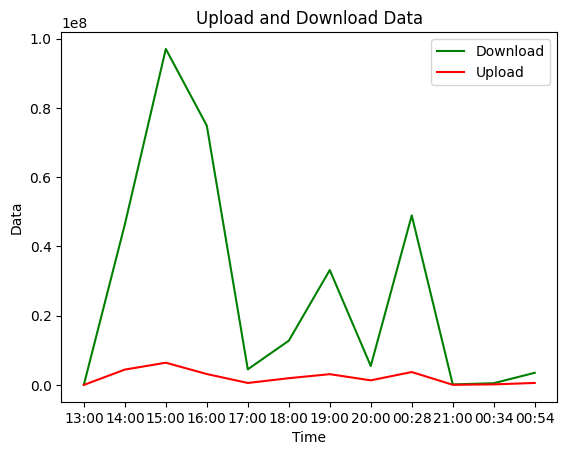

In [8]:
# Draw lines
plt.plot(df.sequence, df.download, color='green', label='Download') # Draw download line
plt.plot(df.sequence, df.upload, color='red', label='Upload') # Draw upload line

# Customize plot
plt.title('Upload and Download Data') # Add title
plt.xlabel('Time') # Give label to x
plt.ylabel('Data') # Give label to y
plt.legend() # Add helper

# Show plot
plt.show()